In [5]:
from janome.tokenizer import Tokenizer
import torch
jtkz = Tokenizer()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [6]:
s = "私は犬が好き。"
ws = [w for w in jtkz.tokenize(s,wakati=True)]
ws

['私', 'は', '犬', 'が', '好き', '。']

In [ ]:
DONE = False

if not DONE:
    from gensim.models.keyedvectors import KeyedVectors
    w2v = KeyedVectors.load_word2vec_format('datasets/entity_vector.model.bin', binary=True)
    DONE = True

import numpy as np
import torch

xn = torch.tensor([w2v[w] for w in ws])
print(xn)
print(ws)
xn.shape

tensor([[-0.9155,  0.9778, -0.4378,  ...,  3.0303, -1.9216,  0.0984],
        [ 0.8603,  0.3643, -1.3381,  ..., -0.4042,  1.1210, -0.4190],
        [ 0.0810,  0.4326,  0.3752,  ...,  1.3360,  0.3233, -1.9915],
        [ 0.4563,  0.2203, -2.7309,  ..., -2.1273,  0.1671, -0.2642],
        [-1.0056, -3.1306, -0.8892,  ..., -1.6494,  0.1720, -1.8252],
        [ 1.4522,  0.0427, -1.3146,  ..., -0.6015, -0.0347,  0.4128]])
['私', 'は', '犬', 'が', '好き', '。']


C:\Users\keisu\AppData\Local\Temp\ipykernel_5072\1985324775.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  xn = torch.tensor([w2v[w] for w in ws])


torch.Size([6, 200])

In [10]:
xn = xn.unsqueeze(0)
xn.shape

torch.Size([1, 6, 200])

In [11]:
import torch.nn as nn

lstm = nn.LSTM(200, 200, batch_first=True)
h0 = torch.randn(1, 1, 200)
c0 = torch.randn(1, 1, 200)
yn, (hn, cn) = lstm(xn, (h0, c0))
yn.shape,hn.shape,cn.shape


(torch.Size([1, 6, 200]), torch.Size([1, 1, 200]), torch.Size([1, 1, 200]))

In [12]:
import pickle

with open('pkls/dic.pkl','br') as f:
    dic = pickle.load(f)

dic['犬']

4373

In [52]:
with open('pkls/xtrain.pkl','br') as f:
    x_data = pickle.load(f)

with open('pkls/ytrain.pkl','br') as f:
    y_data = pickle.load(f)
    
#x_data = torch.from_numpy(x_data)


x_data[6],y_data[6]

([74, 75, 2, 60, 76, 62, 5, 6], [9, 0, 1, 8, 5, 7, 3, 4])

In [13]:
class MyLSTM(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim)
        self.lstm = nn.LSTM(hdim, hdim, batch_first=True)
        self.ln = nn.Linear(hdim, posn)
        
    def forward(self, x):
        ex = self.embd(x)
        lo = self.lstm(ex)
        out = self.ln(lo)
        
        return out
        

In [15]:
labels = {'名詞':0, '助詞':1, '形容詞':2, '助動詞':3, '補助動詞':4, '動詞':5, '代名詞':6, '接尾辞':7, '副詞':8, '形状詞':9, '記号':10, '連体詞':11, '接頭辞':12, '接続詞':13, '感動詞':14, '空白':15}

In [16]:
net = MyLSTM(len(dic), len(labels), 100).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
for ep in range(10):
    losslk = 0.0
    for i in range(len(x_data)):
        x = [ x_data[i] ]
        x = torch.LongTensor(x).to(device)
        output = net(x)
        y = torch.LongTensor( y_data[i] ).to(device)
        loss = criterion(output[0],y)
        if (i % 1000 == 0):
            print(i, losslk)
            losslk = loss.item()
        else:
            losslk += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outfile = 'letm0-' + str(ep) + '.model'
    torch.save(net.state_dict(), outfile)

In [ ]:
with open('pkls/xtrain.pkl','br') as f:
    xtrain = pickle.load(f)

with open('pkls/ytrain.pkl','br') as f:
    ytrain = pickle.load(f)

# Define model

class MyLSTM(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim)
        self.ln   = nn.Linear(hdim, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out

# model generate, optimizer and criterion setting

net = MyLSTM(len(dic)+1, len(labels), 100).to(device)
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

# Learn

for ep in range(1,11):
    loss1K = 0.0
    for i in range(len(xtrain)):
        x = [ xtrain[i] ]
        x = torch.LongTensor(x).to(device)
        output = net(x)
        y = torch.LongTensor( ytrain[i] ).to(device)
        loss = criterion(output[0],y)
        if (i % 1000 == 0):
            print(i, loss1K)
            loss1K = loss.item()
        else:
            loss1K += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outfile = "models/" + "lstm0-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)

In [20]:
net = MyLSTM(len(dic)+1, len(labels),100).to(device)
net.load_state_dict(torch.load('models/lstm0-10.model'))

<All keys matched successfully>

In [32]:
with open('pkls/xtest.pkl','br') as f:
    x_test = pickle.load(f)

with open('pkls/ytest.pkl','br') as f:
    y_test = pickle.load(f)


real_data_num = 0
net.eval()
ok = np.zeros(10)

for j in range(10):
    net.load_state_dict(torch.load('models/lstm0-' + str(j+1) + '.model'))
    real_data_num = 0
    net.eval()
    
    with torch.no_grad():
        for i in range(len(x_test)):
            real_data_num += len(x_test[i])
            x = [ x_test[i] ]
            x = torch.LongTensor(x).to(device)
            output = net(x)
            ans = torch.argmax(output[0],dim=1)
            y = torch.LongTensor( y_test[i] ).to(device)
            ok[j] += torch.sum(ans == y).item()
        print(ok[j], real_data_num, ok[j]/real_data_num)

23721.0 27271 0.8698250889222984
24425.0 27271 0.8956400572036229
24798.0 27271 0.9093175901140406
25030.0 27271 0.9178247955703861
25128.0 27271 0.9214183564959114
25250.0 27271 0.9258919731583001
25324.0 27271 0.9286054783469619
25394.0 27271 0.93117230757948
25434.0 27271 0.9326390671409189
25468.0 27271 0.933885812768142


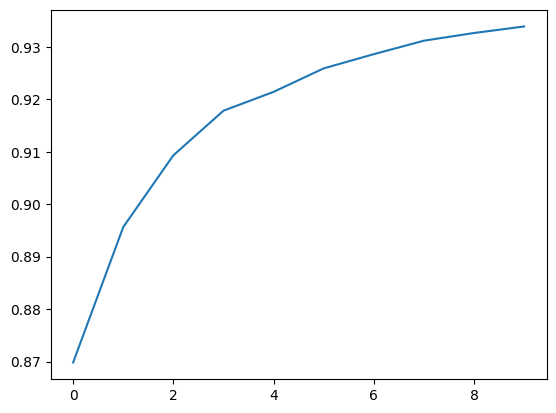

In [34]:
import matplotlib.pyplot as plt

plt.plot(ok/real_data_num)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.data = x_data
        self.label = y_data
        
    def __len__(self):
        return len(self.label)
        
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        
        return x,y

def my_collate_fn(batch):
    x_data, y_data = list(zip(*batch))
    #print(x_data)
    xs = list(x_data)
    ys = list(y_data)
    return xs, ys

with open('pkls/xtrain.pkl','br') as f:
    x_data = pickle.load(f)

with open('pkls/ytrain.pkl','br') as f:
    y_data = pickle.load(f)
    
batch_size = 200

dataset = MyDataset(x_data, y_data)
dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

In [46]:
dataLoader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=my_collate_fn)
dl = dataLoader.__iter__()
xs,ys = dl.__next__()
xs,ys

([1041, 164, 2, 901, 8, 738, 132, 3395, 34, 29162, 394, 14, 725, 55, 56, 19, 7, 60, 206, 1168, 222, 6], [622, 10, 1624, 10, 367, 87, 103, 1143, 8, 17804, 38, 1823, 29, 30, 8, 3352, 69, 34, 2, 14, 15, 17, 10, 19, 377, 11050, 107, 14, 98, 14, 8, 20385, 3753, 3, 895, 366, 81, 19, 107, 14, 44, 6])


([[1041,
   164,
   2,
   901,
   8,
   738,
   132,
   3395,
   34,
   29162,
   394,
   14,
   725,
   55,
   56,
   19,
   7,
   60,
   206,
   1168,
   222,
   6],
  [622,
   10,
   1624,
   10,
   367,
   87,
   103,
   1143,
   8,
   17804,
   38,
   1823,
   29,
   30,
   8,
   3352,
   69,
   34,
   2,
   14,
   15,
   17,
   10,
   19,
   377,
   11050,
   107,
   14,
   98,
   14,
   8,
   20385,
   3753,
   3,
   895,
   366,
   81,
   19,
   107,
   14,
   44,
   6]],
 [[0, 1, 3, 2, 4, 0, 1, 0, 1, 2, 5, 1, 5, 0, 7, 1, 1, 8, 5, 7, 0, 4],
  [0,
   1,
   0,
   1,
   0,
   3,
   1,
   1,
   4,
   9,
   3,
   0,
   1,
   1,
   4,
   9,
   7,
   1,
   5,
   1,
   5,
   3,
   1,
   1,
   0,
   7,
   5,
   1,
   5,
   1,
   4,
   0,
   7,
   1,
   0,
   2,
   0,
   1,
   5,
   3,
   3,
   4]])

In [47]:
from torch.nn.utils.rnn import pad_sequence
a = torch.LongTensor([10,20,30])
b = torch.LongTensor([15,25,35,45,55])
c = torch.LongTensor([68,88])
x = pad_sequence([a,b,c], batch_first=True)
x

tensor([[10, 20, 30,  0,  0],
        [15, 25, 35, 45, 55],
        [68, 88,  0,  0,  0]])

In [48]:
xs1, ys1 = [],[]

for k in range(len(xs)):
    ids = xs[k]
    xs1.append(torch.LongTensor(ids))
    ids = ys[k]
    ys1.append(torch.LongTensor(ids))

xs1 = pad_sequence(xs1, batch_first=True,padding_value=0)
ys1 = pad_sequence(ys1, batch_first=True,padding_value=-1.0)


In [49]:
class MyLSTM(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True)
        self.ln   = nn.Linear(hdim, posn)
        
    def forward(self, x):
        x = self.embd(x)
        lo = self.lstm(x)
        out = self.ln(lo)
        return out

In [50]:
net = MyLSTM(len(dic)+1, len(labels), 100).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
net.train()

for ep in range(10):
    loss10B, i = 0.0, 0
    
    for xs,ys in dataLoader:
        xs1, ys1 = [],[]

        for k in range(len(xs)):
            ids = xs[k]
            xs1.append(torch.LongTensor(ids))
            ids = ys[k]
            ys1.append(torch.LongTensor(ids))
        
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True,padding_value=-1.0)
        
        output = net(xs1)
        
        ys1 = ys1.type(torch.LongTensor).to(device)
        loss = criterion(output[0],ys1[0])
        
        for h in range(1,len(ys1)):
            loss += criterion(output[h],ys1[h])
            
        if (i % 10 == 0):
            print(ep, i, loss10B)
            loss10B = 0.0
        else:
            loss10B += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    outfile = "lstm1-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)
        
        

In [25]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

import pickle

###################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

##################

with open('pkls/dic.pkl','br') as f:
    dic = pickle.load(f)

labels = {'名詞':0, '助詞':1, '形容詞':2, '助動詞':3, '補助動詞':4, '動詞':5, '代名詞':6, '接尾辞':7, '副詞':8, '形状詞':9, '記号':10, '連体詞':11, '接頭辞':12, '接続詞':13, '感動詞':14, '空白':15}

# Data setting

class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.data = xdata
        self.label = ydata
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        return x, y

def my_collate_fn(batch):
    xdata, ydata = list(zip(*batch))
    xs = list(xdata)
    ys = list(ydata)
    return xs, ys
    
# def my_collate_fn(batch):
#     images, targets= list(zip(*batch))
#     xs = list(images)
#     ys = list(targets)
#     return xs, ys

with open('pkls/xtrain.pkl','br') as fr:
    xdata = pickle.load(fr)

with open('pkls/ytrain.pkl','br') as fr:
    ydata = pickle.load(fr)

batch_size = 200
dataset = MyDataset(xdata,ydata)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

# Define model

class MyLSTM1(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM1, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True)
        self.ln   = nn.Linear(hdim, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out

# class MyLSTM(nn.Module):
#     def __init__(self, vocsize, posn, hdim):
#         super(MyLSTM, self).__init__()
#         self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
#         self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim)
#         self.ln   = nn.Linear(hdim, posn)
#     def forward(self, x):
#         x = self.embd(x)
#         lo, (hn, cn) = self.lstm(x)
#         out = self.ln(lo)
#         return out

# model generate, optimizer and criterion setting

net = MyLSTM1(len(dic)+1, len(labels), 100)
optimizer = optim.SGD(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

net.to(device)
# Learn

net.train()
for ep in range(10):
    loss10B, i = 0.0, 0
    for xs, ys in dataloader:
        xs1, ys1 = [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid))
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0)
        output = net(xs1)
        ys1 = ys1.type(torch.LongTensor).to(device)
        loss = criterion(output[0],ys1[0])
        for h in range(1,len(ys1)):
            loss += criterion(output[h],ys1[h])
        if (i % 10 == 0):
            print(ep, i, loss10B)
            loss10B = 0.0
        else:
            loss10B += loss.item()
        i += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outfile = "lstm1-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)


0 0 0.0
0 10 3213.7396240234375
0 20 2205.8760986328125
0 30 1844.2413024902344
0 40 1629.8434600830078
0 50 1475.8739624023438
0 60 1355.644775390625
0 70 1279.9686279296875
0 80 1167.744255065918
0 90 1122.0108642578125
0 100 1061.2952270507812
0 110 1009.3941421508789
0 120 980.9094390869141
0 130 945.7936401367188
0 140 911.1571884155273
0 150 900.6539535522461
0 160 841.9876556396484
0 170 832.4038467407227
0 180 806.5688018798828
0 190 785.5213470458984
0 200 752.2200393676758
0 210 748.8351898193359
0 220 733.6215057373047
0 230 695.3652496337891
0 240 691.9533462524414
1 0 0.0
1 10 666.1027069091797
1 20 646.2052459716797
1 30 630.1465797424316
1 40 640.127685546875
1 50 609.5060157775879
1 60 624.1566543579102
1 70 589.5278396606445
1 80 576.4742965698242
1 90 563.8991851806641
1 100 574.7659721374512
1 110 557.5064315795898
1 120 552.8491897583008
1 130 534.518123626709
1 140 542.7915382385254
1 150 532.6576919555664
1 160 530.7885246276855
1 170 523.5406036376953
1 180 528.4

In [3]:
real_data_num = 0
net.eval()
with torch.no_grad():
    ok = 0
    for xs, ys in dataloader:
        xs1, ys1 = [], []
        for k in range(len(xs)):
            real_data_num += len(xs[k])
            tid = xs[k]
            xs1.append(torch.LongTensor(tid))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid))
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0).to(device)
        output = net(xs1)
        ans = torch.argmax(output,dim=2)
        ok += torch.sum(ans == ys1).item()
print(ok, real_data_num, ok/real_data_num)

1286114 1329489 0.9673746830549181


In [ ]:
with open('pkls/xtest.pkl','br') as fr:
    xtest = pickle.load(fr)

with open('pkls/ytest.pkl','br') as fr:
    ytest = pickle.load(fr)

batch_size = 200
test_dataset = MyDataset(xtest,ytest)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)


real_data_num = 0
net.eval()
with torch.no_grad():
    ok = 0
    for xs, ys in test_dataloader:
        xs1, ys1 = [], []
        for k in range(len(xs)):
            real_data_num += len(xs[k])
            tid = xs[k]
            xs1.append(torch.LongTensor(tid))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid))
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0).to(device)
        output = net(xs1)
        ans = torch.argmax(output,dim=2)
        ok += torch.sum(ans == ys1).item()
print(ok, real_data_num, ok/real_data_num)

26189 27271 0.960324153863078


In [27]:
#2layers lstm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

import pickle

###################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

##################

with open('pkls/dic.pkl','br') as f:
    dic = pickle.load(f)

labels = {'名詞':0, '助詞':1, '形容詞':2, '助動詞':3, '補助動詞':4, '動詞':5, '代名詞':6, '接尾辞':7, '副詞':8, '形状詞':9, '記号':10, '連体詞':11, '接頭辞':12, '接続詞':13, '感動詞':14, '空白':15}

# Data setting

class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.data = xdata
        self.label = ydata
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        return x, y

def my_collate_fn(batch):
    xdata, ydata = list(zip(*batch))
    xs = list(xdata)
    ys = list(ydata)
    return xs, ys
    
# def my_collate_fn(batch):
#     images, targets= list(zip(*batch))
#     xs = list(images)
#     ys = list(targets)
#     return xs, ys

with open('pkls/xtrain.pkl','br') as fr:
    xdata = pickle.load(fr)

with open('pkls/ytrain.pkl','br') as fr:
    ydata = pickle.load(fr)

batch_size = 200
dataset = MyDataset(xdata,ydata)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

# Define model

class MyLSTM2(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM2, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True, num_layers=2)
        self.ln   = nn.Linear(hdim, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out

# class MyLSTM(nn.Module):
#     def __init__(self, vocsize, posn, hdim):
#         super(MyLSTM, self).__init__()
#         self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
#         self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim)
#         self.ln   = nn.Linear(hdim, posn)
#     def forward(self, x):
#         x = self.embd(x)
#         lo, (hn, cn) = self.lstm(x)
#         out = self.ln(lo)
#         return out

# model generate, optimizer and criterion setting

net = MyLSTM2(len(dic)+1, len(labels), 100)
optimizer = optim.SGD(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

net.to(device)
# Learn

net.train()
for ep in range(10):
    loss10B, i = 0.0, 0
    for xs, ys in dataloader:
        xs1, ys1 = [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid))
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0)
        output = net(xs1)
        ys1 = ys1.type(torch.LongTensor).to(device)
        loss = criterion(output[0],ys1[0])
        for h in range(1,len(ys1)):
            loss += criterion(output[h],ys1[h])
        if (i % 10 == 0):
            print(ep, i, loss10B)
            loss10B = 0.0
        else:
            loss10B += loss.item()
        i += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outfile = "lstm1-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)


0 0 0.0
0 10 3815.413055419922
0 20 3508.0667114257812
0 30 3224.7688903808594
0 40 2682.1385192871094
0 50 2217.046142578125
0 60 1969.7098388671875
0 70 1778.5794982910156
0 80 1700.7825012207031
0 90 1570.8703002929688
0 100 1507.7458953857422
0 110 1395.2925567626953
0 120 1345.0011138916016
0 130 1309.4606475830078
0 140 1244.2055358886719
0 150 1222.10546875
0 160 1150.3037185668945
0 170 1154.6723175048828
0 180 1085.9028854370117
0 190 1025.2031860351562
0 200 1013.7633514404297
0 210 984.7750778198242
0 220 940.1288452148438
0 230 905.566162109375
0 240 899.7625045776367
1 0 0.0
1 10 851.1903305053711
1 20 775.6264801025391
1 30 783.796012878418
1 40 775.421516418457
1 50 721.2808303833008
1 60 753.6771392822266
1 70 698.4956512451172
1 80 678.6510696411133
1 90 664.2647399902344
1 100 625.7179183959961
1 110 641.2987213134766
1 120 609.5427169799805
1 130 612.889030456543
1 140 599.4219131469727
1 150 588.1988906860352
1 160 582.416690826416
1 170 563.68603515625
1 180 539.44

In [24]:
#class MyLSTM1 and 2

class MyLSTM1(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM1, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True, num_layers=1)
        self.ln   = nn.Linear(hdim, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out

class MyLSTM2(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTM2, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True, num_layers=2)
        self.ln   = nn.Linear(hdim, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out
    

In [ ]:
#1layers lstm test
with open('pkls/xtest.pkl','br') as fr:
    xtest = pickle.load(fr)

with open('pkls/ytest.pkl','br') as fr:
    ytest = pickle.load(fr)

net = MyLSTM1(len(dic)+1, len(labels), 100).to(device)
batch_size = 200
test_dataset = MyDataset(xtest,ytest)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)


real_data_num = 0
#net.eval()
lstm1ok = np.zeros(10)

for j in range(10):
    net.load_state_dict(torch.load('lstm1-' + str(j) + '.model'))
    real_data_num = 0
    net.eval()
    
    with torch.no_grad():
        
        for xs, ys in test_dataloader:
            xs1, ys1 = [], []
            for k in range(len(xs)):
                real_data_num += len(xs[k])
                tid = xs[k]
                xs1.append(torch.LongTensor(tid))
                tid = ys[k]
                ys1.append(torch.LongTensor(tid))
            xs1 = pad_sequence(xs1, batch_first=True).to(device)
            ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0).to(device)
            output = net(xs1)
            ans = torch.argmax(output,dim=2)
            lstm1ok[j] += torch.sum(ans == ys1).item()
print(lstm1ok[j], real_data_num, lstm1ok[j]/real_data_num)

import matplotlib.pyplot as plt
plt.plot(lstm1ok/real_data_num)

26272.0 27271 0.9633676799530637


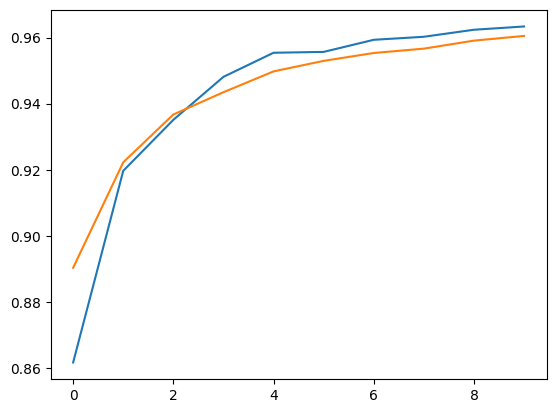

In [ ]:
#2layers lstm test

net = MyLSTM2(len(dic)+1, len(labels), 100)

real_data_num = 0
#net.eval()
lstm2ok = np.zeros(10)

for j in range(10):
    net.load_state_dict(torch.load('lstm1-' + str(j) + '.model'))
    real_data_num = 0
    net.eval()
    
    with torch.no_grad():
        
        for xs, ys in test_dataloader:
            xs1, ys1 = [], []
            for k in range(len(xs)):
                real_data_num += len(xs[k])
                tid = xs[k]
                xs1.append(torch.LongTensor(tid))
                tid = ys[k]
                ys1.append(torch.LongTensor(tid))
            xs1 = pad_sequence(xs1, batch_first=True)
            ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0)
            output = net(xs1)
            ans = torch.argmax(output,dim=2)
            lstm2ok[j] += torch.sum(ans == ys1).item()
print(lstm2ok[j], real_data_num, lstm2ok[j]/real_data_num)

import matplotlib.pyplot as plt
plt.plot(lstm2ok/real_data_num)
plt.plot(lstm1ok/real_data_num)

In [31]:
class MyLSTMbidir(nn.Module):
    def __init__(self, vocsize, posn, hdim):
        super(MyLSTMbidir, self).__init__()
        self.embd = nn.Embedding(vocsize, hdim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hdim, hidden_size=hdim, batch_first=True, num_layers=2, bidirectional=True)
        self.ln   = nn.Linear(hdim*2, posn)
    def forward(self, x):
        x = self.embd(x)
        lo, (hn, cn) = self.lstm(x)
        out = self.ln(lo)
        return out
    
net = MyLSTMbidir(len(dic)+1, len(labels), 100).to(device)
optimizer = optim.Adam(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

net.train()
for ep in range(10):
    loss10B, i = 0.0, 0
    for xs, ys in dataloader:
        xs1, ys1 = [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid))
        xs1 = pad_sequence(xs1, batch_first=True).to(device)
        ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0)
        output = net(xs1)
        ys1 = ys1.type(torch.LongTensor).to(device)
        loss = criterion(output[0],ys1[0])
        for h in range(1,len(ys1)):
            loss += criterion(output[h],ys1[h])
        if (i % 10 == 0):
            print(ep, i, loss10B)
            loss10B = 0.0
        else:
            loss10B += loss.item()
        i += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outfile = "lstm1-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)

0 0 0.0
0 10 2799.464569091797
0 20 1228.5734786987305
0 30 736.5381469726562
0 40 510.93906021118164
0 50 389.1900444030762
0 60 317.10545539855957
0 70 264.37635231018066
0 80 245.48476791381836
0 90 211.42030715942383
0 100 186.84514045715332
0 110 160.3326005935669
0 120 157.13044357299805
0 130 146.40859127044678
0 140 139.5210771560669
0 150 136.11452770233154
0 160 127.09483814239502
0 170 111.9351224899292
0 180 111.72396087646484
0 190 107.70082950592041
0 200 106.02264451980591
0 210 107.9072208404541
0 220 97.79469394683838
0 230 99.89946937561035
0 240 88.64101219177246
1 0 0.0
1 10 48.21272802352905
1 20 54.92523717880249
1 30 48.77601671218872
1 40 46.23015260696411
1 50 41.54210925102234
1 60 46.916078090667725
1 70 49.39334201812744
1 80 47.42792844772339
1 90 43.6591534614563
1 100 44.54586100578308
1 110 47.4345326423645
1 120 46.82586884498596
1 130 48.23607349395752
1 140 50.42310094833374
1 150 47.99651336669922
1 160 43.72019600868225
1 170 45.60896873474121
1 180

26989.0 27271 0.9896593450918558


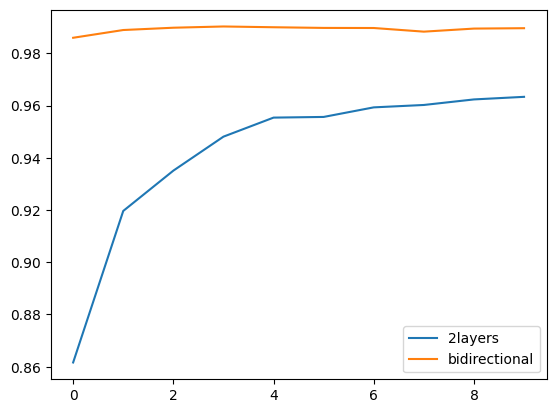

In [33]:
#bidirectional lstm test

net = MyLSTMbidir(len(dic)+1, len(labels), 100)

real_data_num = 0
#net.eval()
lstmbiok = np.zeros(10)

for j in range(10):
    net.load_state_dict(torch.load('lstm1-' + str(j) + '.model'))
    real_data_num = 0
    net.eval()
    
    with torch.no_grad():
        
        for xs, ys in test_dataloader:
            xs1, ys1 = [], []
            for k in range(len(xs)):
                real_data_num += len(xs[k])
                tid = xs[k]
                xs1.append(torch.LongTensor(tid))
                tid = ys[k]
                ys1.append(torch.LongTensor(tid))
            xs1 = pad_sequence(xs1, batch_first=True)
            ys1 = pad_sequence(ys1, batch_first=True, padding_value=-1.0)
            output = net(xs1)
            ans = torch.argmax(output,dim=2)
            lstmbiok[j] += torch.sum(ans == ys1).item()
print(lstmbiok[j], real_data_num, lstmbiok[j]/real_data_num)

plt.plot(lstm2ok/real_data_num, label='2layers')
#plt.plot(lstm1ok/real_data_num, label='1layer')
plt.plot(lstmbiok/real_data_num, label='bidirectional')
plt.legend()